In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import db_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
metric_names = {
    'auc_rnx': '$AUC_{log}RNX$',
    'pearsonr': 'CC',
    'cca_stress': 'CCA',
    'mds_isotonic': 'nMDS',
    'sammon_nlm': 'NLM'
}

dataset_names = [
    'MNIST-SMALL',
    'COIL20',
    'COUNTRY-2014',
    'BREAST-CANCER95',
    'MPI',
    'DIABETES'
]

In [40]:
def load_scores(dataset_name = 'MNIST-SMALL', standardized=True):
    # print('Loading scores for ', dataset_name)
    db_name = 'DB_{}'.format(dataset_name)
    constraint_key_name = 'constraints'
    metric_key_name = 'metrics'

    # load metric scores and sort the record by perplexity
    dfm = db_utils.load_data(db_name, metric_key_name)
    dfm = dfm.sort_values('perp')
    # remove record with max_perp
    dfm = dfm[dfm.perp < dfm.perp.max()]

    # use negative value of 3 unbounded metrics
    dfm.cca_stress *= -1
    dfm.mds_isotonic *= -1
    dfm.sammon_nlm *= -1
    
    # load constraint scores
    dfc = db_utils.load_data(db_name, constraint_key_name)
    dfc = dfc.loc[:, dfc.columns != 'reproduce_seed']
    # only work with `n_constraints > 5`
    dfc = dfc[dfc.n_constraints > 5]
    # remove record with max_perp
    dfc = dfc[dfc.perp < dfc.perp.max()]
    # group by perplexity
    dfc = dfc.groupby('perp').mean()

    perps = dfm.perp
    assert 0.0 == np.sum(perps - dfc.index)
    
    if standardized:
        # after getting the index (perp column), do standardize
        dfm = (dfm - dfm.mean()) / dfm.std()
        dfc = (dfc - dfc.mean()) / dfc.std()
    
    return perps, dfm, dfc

### Calculate cosine distance between metric scores and constraint scores

In [41]:
from scipy.spatial.distance import cosine

def _cosine_dists(dfc, dfm, metric_name):
    metric_scores = dfm[metric_name]
    return {
        'ML + CL': cosine(dfc.s_all, metric_scores),
        'ML only': cosine(dfc.s_ml, metric_scores),
        'CL only': cosine(dfc.s_cl, metric_scores)
    }

In [42]:
bar_colors = ["#ff9900", "#3366cc", "#dc3912"] # 3 different colors corresponding to `ML + CL`, `ML only` and `CL only`

def _plot_barh_cosine_dists(ax, names, values): #, show_xaxis=False, show_yaxis=False, ylabel=None, subtitle=None):
    y_pos = np.arange(len(names))
    ax.barh(y_pos, values, height=0.5, color=bar_colors)
    ax.margins(0.2, 0.2)
    
    # adjust x-ticks: to make room for annotation next to the bar
    ax.axes.set_xlim(0, 2.5)
    # but it should show only the values from 0.0 to 2.0
    ax.xaxis.set_ticklabels([0.0, 0.5, 1.0, 1.5, 2.0])
    # temporarily hiding
    ax.xaxis.set_visible(False)

    # adjust y-ticks: do not sort `names`, just show in invert order as given in `names`
    ax.invert_yaxis()
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    # temporarily hidibg
    ax.yaxis.set_visible(False)
    
    # show annotation next to the bar
    for i, p in enumerate(ax.patches):
        ax.text(p.get_width() + 0.05, p.get_y() + 0.4, '{:.3f}'.format(values[i]))

In [51]:
def _plot_bars_in_a_row(dfm, dfc, row_axes): #, ylabel=None, subtitle=None):
    for i, metric_key in enumerate(metric_names):
        metric_name = metric_names[metric_key]
        dists = _cosine_dists(dfc, dfm, metric_key)
        
        is_first_item = (i == 0)
        _plot_barh_cosine_dists(row_axes[i],
                                names=list(dists.keys()),
                                values=list(dists.values()))

def _plot_bars_in_matrix():
    fig, axes = plt.subplots(6, 5, figsize=(16, 8))
    
    for i, dataset_name in enumerate(dataset_names):
        row_axes = axes[i]
        _, dfm, dfc = load_scores(dataset_name, standardized=True)
        _plot_bars_in_a_row(dfm, dfc, row_axes)
    
    # adjust matrix to show:
    # (1) sub title (metric name) for each column
    for i, metric_key in enumerate(metric_names):
        metric_name = metric_names[metric_key]
        axes[0][i].set_title(metric_name, fontsize=14)
    
    # (2.1) ylabel (dataset name) for each row
    for i, dataset_name in enumerate(dataset_names):
        axes[i][0].yaxis.set_visible(True)
        axes[i][0].yaxis.set_ticks([])
        # axes[i][0].tick_params('y', labelsize=8, right=True)
        display_name = '\n'.join(dataset_name.split('-'))
        axes[i][0].set_ylabel(display_name, rotation=90, fontsize=14)
        
    # (2.2) y-ticklabels (constraint types) in right side
    for i in range(len(dataset_names)):
        last_col_id = len(metric_names) - 1
        axes[i][last_col_id].yaxis.set_visible(True)
        axes[i][last_col_id].yaxis.tick_right()
        
    # (3) show xlabel in last row
    last_row_id = len(dataset_names) - 1
    for i in range(len(metric_names)):
        axes[last_row_id][i].xaxis.set_visible(True)
        # axes[last_row_id][i].set_xlabel('Cosine distance')

    # (4) remove space between subplots
    plt.subplots_adjust(hspace=0, wspace=0, left=0.06, right=0.94, bottom=0.1, top=0.9)
    
    # (5) tight layour (if needed)
    # plt.tight_layout()
    
    plt.rcParams.update({'font.size': 14})
    plt.savefig('./plots/cosine_distance.pdf')

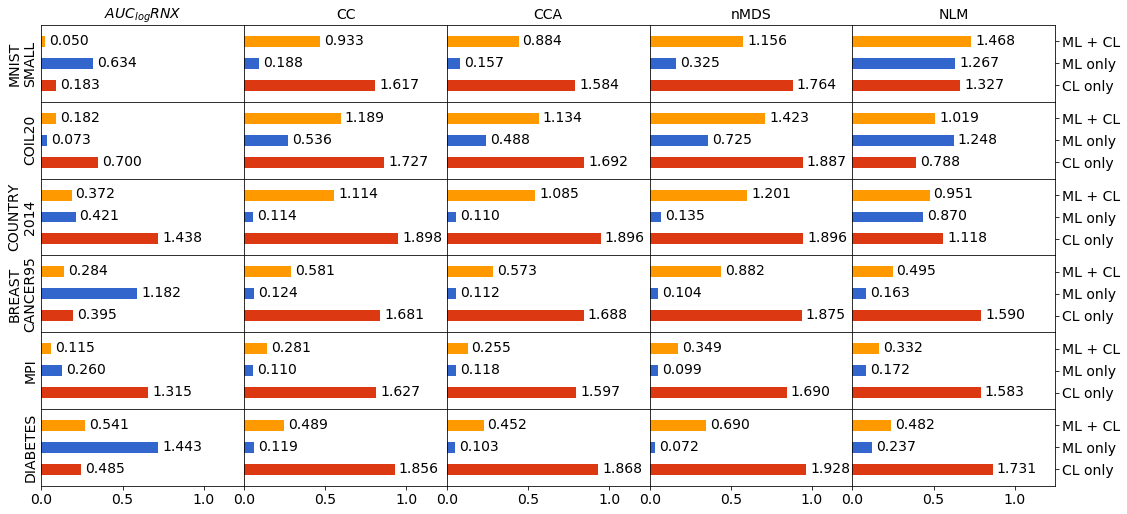

In [52]:
_plot_bars_in_matrix()